# Project 2

## Process
* create a small data set (only 12 elements) to look at text processing and see how BoW vectorization works
* create vectors for the data
    * default
    * exclude common words
    * exclude rare words
    * count # of times word is used in single review? or just present at all
    * look at word pairs? word triples? expensive to generate, could produce better results
* train a simple logistic regression on the data
    * look at all different vectors, see which set is best
* tweak logistic hyperparams
* train MLP
* train decision tree

In [1]:
# imports

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


## Data processing
* Removing whitespace and punctuation
* Converting to all lowercase
* Generating vectors

### Default BoW

In [2]:
# big
raw_reviews = pd.read_csv('data/data_reviews/x_train.csv')['text'].values.tolist()
reviews = list()

pattern = re.compile('[^a-z ]')
for review in raw_reviews:
    review = review.lower()
    review = pattern.sub('', review)
    reviews.append(review)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews)
y = pd.read_csv('data/data_reviews/y_train.csv').to_numpy().ravel()

In [3]:
# # small
# raw_reviews_short = pd.read_csv('data/data_reviews/x_train_small.csv')['text'].values.tolist()
# reviews_short = list()

# pattern = re.compile('[^a-z ]')
# for review_short in raw_reviews_short:
#     review_short = review_short.lower()
#     review_short = pattern.sub('', review_short)
#     reviews_short.append(review_short)

# vectorizer_short = CountVectorizer()
# X_short = vectorizer_short.fit_transform(reviews_short)
# y_short = pd.read_csv('data/data_reviews/y_train_small.csv').to_numpy().ravel()
# # vectorizer_short.get_feature_names()

### BOW w 

## Logistic regression

### Default

In [4]:
kf = KFold(shuffle=True)
log_model = linear_model.LogisticRegression()

k_train_losses = list()
k_train_scores = list()
k_train_aucs = list()

k_val_losses = list()
k_val_scores = list()
k_val_aucs = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_model.fit(x_train, y_train)
    
    train_probas = minmax_scale(log_model.decision_function(x_train).reshape(-1,1))
    val_probas = minmax_scale(log_model.decision_function(x_val).reshape(-1, 1))
    # for i in train_probas:
    #     print(i, end=' ') 
    # print()
    k_train_losses.append(log_loss(y_train, train_probas))
    k_train_scores.append(log_model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
    k_val_losses.append(log_loss(y_val, val_probas))
    k_val_scores.append(log_model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
    print('   TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
        k_train_aucs[-1],
        k_train_losses[-1],
        k_train_scores[-1]))

    print('   TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
        k_val_aucs[-1],
        k_val_losses[-1],
        k_val_scores[-1]))

print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
    np.mean(k_train_aucs),
    np.mean(k_train_losses),
    np.mean(k_train_scores)))

print('TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
    np.mean(k_val_aucs),
    np.mean(k_val_losses),
    np.mean(k_val_scores)))
print('std:', np.std(k_val_scores))

   TRAIN -- auc: 0.995528   loss: 0.510873   score: 0.978125
   TEST --  auc: 0.887683   loss: 0.568771   score: 0.816667
   TRAIN -- auc: 0.994896   loss: 0.520082   score: 0.980208
   TEST --  auc: 0.890217   loss: 0.543340   score: 0.825000
   TRAIN -- auc: 0.995890   loss: 0.514649   score: 0.979167
   TEST --  auc: 0.891401   loss: 0.575994   score: 0.822917
   TRAIN -- auc: 0.994241   loss: 0.509373   score: 0.980208
   TEST --  auc: 0.872393   loss: 0.585202   score: 0.797917
   TRAIN -- auc: 0.995087   loss: 0.494230   score: 0.980729
   TEST --  auc: 0.859687   loss: 0.577800   score: 0.793750
TRAIN -- auc: 0.995128   loss: 0.509841   score: 0.979688
TEST --  auc: 0.880276   loss: 0.570221   score: 0.811250
std: 0.012950225223266694


### LBFGS L2
best C: 8.68511373751352

In [6]:
# find best C
train_scores = list()
train_aucs = list()
train_losses = list()

val_scores = list()
val_aucs = list()
val_losses = list()

best_c = 10**-2
best_loss = 1000

kf = KFold(shuffle=True)
for c in np.logspace(-2, 2, 50):
    log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=c)
    
    k_train_scores = list()
    k_train_aucs = list()
    k_train_losses = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    k_val_losses = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        log_model.fit(x_train, y_train)
        
        train_probas = minmax_scale(log_model.decision_function(x_train))
        val_probas = minmax_scale(log_model.decision_function(x_val))
                
        k_train_scores.append(log_model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        k_train_losses.append(log_loss(y_train, train_probas))

        k_val_scores.append(log_model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))
        k_val_losses.append(log_loss(y_val, val_probas))

    if np.mean(k_val_losses) < best_loss:
        best_c = c
        best_loss = np.mean(k_val_losses)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    train_losses.append(np.mean(k_train_losses))

    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    val_losses.append(np.mean(k_val_losses))

    print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        c,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))

print('best C:', best_c)

C: 0.010000   score: 0.717500   auc: 0.785773   loss: 0.626573
C: 0.012068   score: 0.725000   auc: 0.798387   loss: 0.599807
C: 0.014563   score: 0.733750   auc: 0.802348   loss: 0.604407
C: 0.017575   score: 0.719167   auc: 0.802869   loss: 0.616614
C: 0.021210   score: 0.735833   auc: 0.805431   loss: 0.591616
C: 0.025595   score: 0.741250   auc: 0.816154   loss: 0.617999
C: 0.030888   score: 0.757500   auc: 0.825447   loss: 0.626307
C: 0.037276   score: 0.759583   auc: 0.830558   loss: 0.608822
C: 0.044984   score: 0.757500   auc: 0.831666   loss: 0.591437
C: 0.054287   score: 0.776667   auc: 0.843723   loss: 0.595100
C: 0.065513   score: 0.777917   auc: 0.845448   loss: 0.592045
C: 0.079060   score: 0.776250   auc: 0.845917   loss: 0.601773
C: 0.095410   score: 0.781667   auc: 0.853695   loss: 0.605772
C: 0.115140   score: 0.785833   auc: 0.857176   loss: 0.588317
C: 0.138950   score: 0.790417   auc: 0.859637   loss: 0.600878
C: 0.167683   score: 0.788750   auc: 0.860453   loss: 0

In [ ]:
# find best tol
train_scores = list()
train_aucs = list()
train_losses = list()

val_scores = list()
val_aucs = list()
val_losses = list()

best_c = 10**-8
best_loss = 1000

kf = KFold(shuffle=True)
for tol in np.logspace(-8, 4, 50):
    log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=best_c)
    
    k_train_scores = list()
    k_train_aucs = list()
    k_train_losses = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    k_val_losses = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        log_model.fit(x_train, y_train)
        
        train_probas = minmax_scale(log_model.decision_function(x_train))
        val_probas = minmax_scale(log_model.decision_function(x_val))
                
        k_train_scores.append(log_model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        k_train_losses.append(log_loss(y_train, train_probas))

        k_val_scores.append(log_model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))
        k_val_losses.append(log_loss(y_val, val_probas))

    if np.mean(k_val_losses) < best_loss:
        best_c = c
        best_loss = np.mean(k_val_losses)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    train_losses.append(np.mean(k_train_losses))

    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    val_losses.append(np.mean(k_val_losses))

    print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        c,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))

print('best C:', best_c)

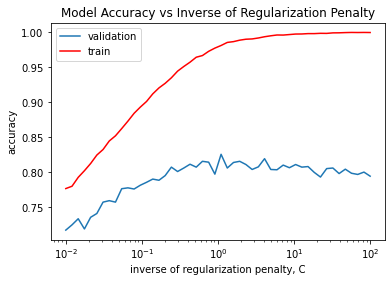

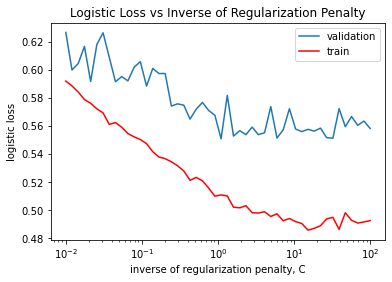

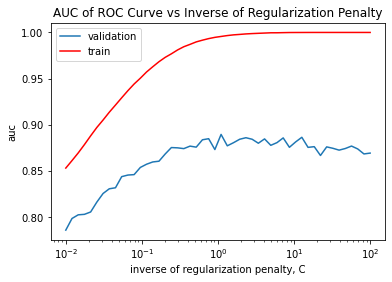

In [7]:
# plots

# plot accuracy
plt.title('Model Accuracy vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('accuracy')
plt.plot(np.logspace(-2, 2, 50), val_scores, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot loss
plt.title('Logistic Loss vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('logistic loss')
plt.plot(np.logspace(-2, 2, 50), val_losses, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot auc
plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('auc')
plt.plot(np.logspace(-2, 2, 50), val_aucs, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

In [8]:
# best model details

kf = KFold(shuffle=True, n_splits=10)
log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=c)

k_train_scores = list()
k_train_aucs = list()
k_train_losses = list()

k_val_scores = list()
k_val_aucs = list()
k_val_losses = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_model.fit(x_train, y_train)

    train_probas = minmax_scale(log_model.decision_function(x_train))
    val_probas = minmax_scale(log_model.decision_function(x_val))
            
    k_train_scores.append(log_model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    k_train_losses.append(log_loss(y_train, train_probas))

    k_val_scores.append(log_model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    k_val_losses.append(log_loss(y_val, val_probas))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_train_scores), 
        np.mean(k_train_aucs),
        np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))
print('std:', np.std(k_val_scores))


TRAIN -- score: 0.999954   auc: 1.000000   loss: 0.492237
VALID -- score: 0.798750   auc: 0.873513   loss: 0.565971
std: 0.01250694251650303


### LBFGS none

In [9]:
# details

kf = KFold(shuffle=True, n_splits=10)
log_model = linear_model.LogisticRegression(solver='lbfgs', penalty='none', max_iter=500)

k_train_scores = list()
k_train_aucs = list()
k_train_losses = list()

k_val_scores = list()
k_val_aucs = list()
k_val_losses = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_model.fit(x_train, y_train)

    train_probas = minmax_scale(log_model.decision_function(x_train))
    val_probas = minmax_scale(log_model.decision_function(x_val))
            
    k_train_scores.append(log_model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    k_train_losses.append(log_loss(y_train, train_probas))

    k_val_scores.append(log_model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    k_val_losses.append(log_loss(y_val, val_probas))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_train_scores), 
        np.mean(k_train_aucs),
        np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))
print('std:', np.std(k_val_scores))

TRAIN -- score: 1.000000   auc: 1.000000   loss: 0.497080
VALID -- score: 0.790417   auc: 0.866725   loss: 0.551916
std: 0.022977192798270405


### liblinear L2
best C: 

In [10]:
# find best C
train_scores = list()
train_aucs = list()
train_losses = list()

val_scores = list()
val_aucs = list()
val_losses = list()

best_c = 10**-2
best_loss = 1000

kf = KFold(shuffle=True)
for c in np.logspace(-2, 2, 50):
    log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', max_iter=500, C=c)
    
    k_train_scores = list()
    k_train_aucs = list()
    k_train_losses = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    k_val_losses = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        log_model.fit(x_train, y_train)
        
        train_probas = minmax_scale(log_model.decision_function(x_train))
        val_probas = minmax_scale(log_model.decision_function(x_val))
                
        k_train_scores.append(log_model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        k_train_losses.append(log_loss(y_train, train_probas))

        k_val_scores.append(log_model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))
        k_val_losses.append(log_loss(y_val, val_probas))

    if np.mean(k_val_losses) < best_loss:
        best_c = c
        best_loss = np.mean(k_val_losses)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    train_losses.append(np.mean(k_train_losses))

    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    val_losses.append(np.mean(k_val_losses))

    print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        c,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))

print('best C:', best_c)

C: 0.010000   score: 0.723750   auc: 0.790077   loss: 0.605600
C: 0.012068   score: 0.725000   auc: 0.793012   loss: 0.598753
C: 0.014563   score: 0.724167   auc: 0.794485   loss: 0.602212
C: 0.017575   score: 0.732917   auc: 0.806537   loss: 0.599082
C: 0.021210   score: 0.741250   auc: 0.808590   loss: 0.615037
C: 0.025595   score: 0.752917   auc: 0.819886   loss: 0.599040
C: 0.030888   score: 0.753333   auc: 0.826081   loss: 0.611290
C: 0.037276   score: 0.761250   auc: 0.830138   loss: 0.603888
C: 0.044984   score: 0.763333   auc: 0.833779   loss: 0.599194
C: 0.054287   score: 0.768750   auc: 0.842328   loss: 0.592747
C: 0.065513   score: 0.765417   auc: 0.840966   loss: 0.583285
C: 0.079060   score: 0.778333   auc: 0.848961   loss: 0.580158
C: 0.095410   score: 0.778750   auc: 0.852804   loss: 0.590903
C: 0.115140   score: 0.787083   auc: 0.858026   loss: 0.594788
C: 0.138950   score: 0.798750   auc: 0.867940   loss: 0.574194
C: 0.167683   score: 0.788333   auc: 0.861575   loss: 0

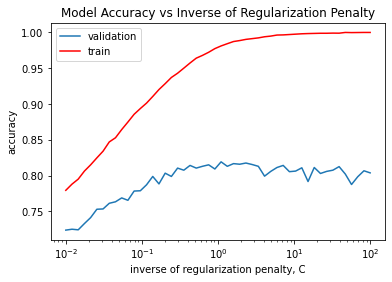

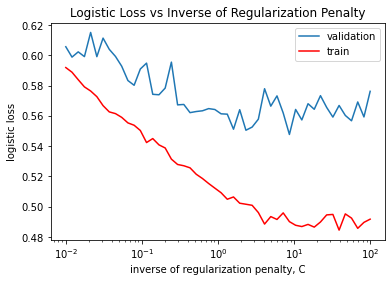

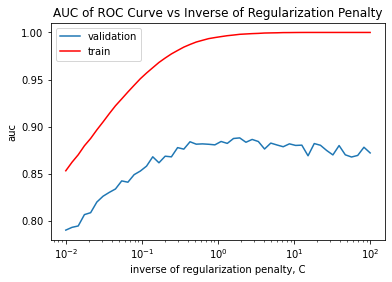

In [11]:
# plots

# plot accuracy
plt.title('Model Accuracy vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('accuracy')
plt.plot(np.logspace(-2, 2, 50), val_scores, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot loss
plt.title('Logistic Loss vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('logistic loss')
plt.plot(np.logspace(-2, 2, 50), val_losses, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot auc
plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('auc')
plt.plot(np.logspace(-2, 2, 50), val_aucs, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

In [12]:
# best model details

kf = KFold(shuffle=True, n_splits=10)
log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l2', max_iter=500, C=c)

k_train_scores = list()
k_train_aucs = list()
k_train_losses = list()

k_val_scores = list()
k_val_aucs = list()
k_val_losses = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_model.fit(x_train, y_train)

    train_probas = minmax_scale(log_model.decision_function(x_train))
    val_probas = minmax_scale(log_model.decision_function(x_val))
            
    k_train_scores.append(log_model.score(x_train, y_train))
    k_train_aucs.append(roc_auc_score(y_train, train_probas))
    k_train_losses.append(log_loss(y_train, train_probas))

    k_val_scores.append(log_model.score(x_val, y_val))
    k_val_aucs.append(roc_auc_score(y_val, val_probas))
    k_val_losses.append(log_loss(y_val, val_probas))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_train_scores), 
        np.mean(k_train_aucs),
        np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))
print('std:', np.std(k_val_scores))

TRAIN -- score: 0.999907   auc: 1.000000   loss: 0.493034
VALID -- score: 0.808333   auc: 0.876904   loss: 0.547947
std: 0.02725904538966021


### liblinear L1
best C: 8.68511373751352

In [13]:
# find best C
train_scores = list()
train_aucs = list()
train_losses = list()

val_scores = list()
val_aucs = list()
val_losses = list()

best_c = 10**-2
best_loss = 1000

kf = KFold(shuffle=True)
for c in np.logspace(-2, 2, 50):
    log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, C=c)
    
    k_train_scores = list()
    k_train_aucs = list()
    k_train_losses = list()
    
    k_val_scores = list()
    k_val_aucs = list()
    k_val_losses = list()
    
    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        log_model.fit(x_train, y_train)
        
        train_probas = minmax_scale(log_model.decision_function(x_train))
        val_probas = minmax_scale(log_model.decision_function(x_val))
                
        k_train_scores.append(log_model.score(x_train, y_train))
        k_train_aucs.append(roc_auc_score(y_train, train_probas))
        k_train_losses.append(log_loss(y_train, train_probas))

        k_val_scores.append(log_model.score(x_val, y_val))
        k_val_aucs.append(roc_auc_score(y_val, val_probas))
        k_val_losses.append(log_loss(y_val, val_probas))

    if np.mean(k_val_losses) < best_loss:
        best_c = c
        best_loss = np.mean(k_val_losses)

    train_scores.append(np.mean(k_train_scores))
    train_aucs.append(np.mean(k_train_aucs))
    train_losses.append(np.mean(k_train_losses))

    val_scores.append(np.mean(k_val_scores))
    val_aucs.append(np.mean(k_val_aucs))
    val_losses.append(np.mean(k_val_losses))

    print('C: {:2f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        c,
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))

print('best C:', best_c)

C: 0.010000   score: 0.500000   auc: 0.500000   loss: 17.269388
C: 0.012068   score: 0.500000   auc: 0.500000   loss: 17.269388
C: 0.014563   score: 0.510000   auc: 0.504180   loss: 16.097088
C: 0.017575   score: 0.547500   auc: 0.595440   loss: 3.393819
C: 0.021210   score: 0.607083   auc: 0.649014   loss: 0.695163
C: 0.025595   score: 0.636667   auc: 0.675757   loss: 0.662668
C: 0.030888   score: 0.636667   auc: 0.684226   loss: 0.715275
C: 0.037276   score: 0.638750   auc: 0.690379   loss: 0.664304
C: 0.044984   score: 0.640833   auc: 0.697375   loss: 0.673424
C: 0.054287   score: 0.637917   auc: 0.694939   loss: 0.660640
C: 0.065513   score: 0.660417   auc: 0.723882   loss: 0.669587
C: 0.079060   score: 0.673333   auc: 0.745617   loss: 0.650711
C: 0.095410   score: 0.677500   auc: 0.752103   loss: 0.633659
C: 0.115140   score: 0.684583   auc: 0.763267   loss: 0.634872
C: 0.138950   score: 0.691667   auc: 0.773668   loss: 0.647765
C: 0.167683   score: 0.699583   auc: 0.789776   loss

C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


C: 3.393222   score: 0.792083   auc: 0.867003   loss: 0.576801
C: 4.094915   score: 0.790000   auc: 0.863824   loss: 0.571323
C: 4.941713   score: 0.806250   auc: 0.872151   loss: 0.562157
C: 5.963623   score: 0.783333   auc: 0.864992   loss: 0.559277
C: 7.196857   score: 0.785417   auc: 0.862530   loss: 0.560109
C: 8.685114   score: 0.795417   auc: 0.871936   loss: 0.575862
C: 10.481131   score: 0.800417   auc: 0.867369   loss: 0.567970
C: 12.648552   score: 0.788750   auc: 0.866345   loss: 0.564737
C: 15.264180   score: 0.794583   auc: 0.865823   loss: 0.575578
C: 18.420700   score: 0.791667   auc: 0.862997   loss: 0.555132
C: 22.229965   score: 0.800417   auc: 0.868722   loss: 0.552198
C: 26.826958   score: 0.790000   auc: 0.860166   loss: 0.570308
C: 32.374575   score: 0.788750   auc: 0.865836   loss: 0.575132
C: 39.069399   score: 0.789167   auc: 0.867414   loss: 0.565015
C: 47.148664   score: 0.792500   auc: 0.863093   loss: 0.577330
C: 56.898660   score: 0.785417   auc: 0.860072

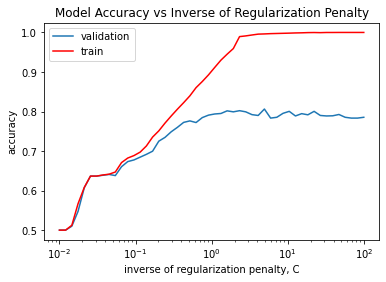

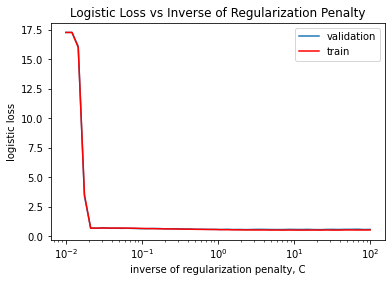

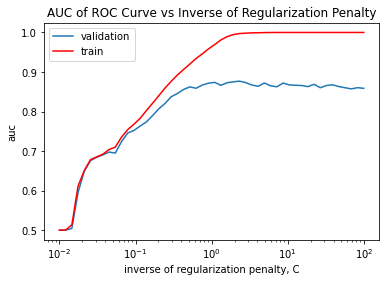

In [14]:
# plots

# plot accuracy
plt.title('Model Accuracy vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('accuracy')
plt.plot(np.logspace(-2, 2, 50), val_scores, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_scores, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot loss
plt.title('Logistic Loss vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('logistic loss')
plt.plot(np.logspace(-2, 2, 50), val_losses, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_losses, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

# plot auc
plt.title('AUC of ROC Curve vs Inverse of Regularization Penalty')
plt.xlabel('inverse of regularization penalty, C')
plt.ylabel('auc')
plt.plot(np.logspace(-2, 2, 50), val_aucs, label='validation')
plt.plot(np.logspace(-2, 2, 50), train_aucs, c='r', label='train')
plt.xscale('log')
plt.legend()
plt.show()

In [15]:
# best model details

kf = KFold(n_splits=10)
log_model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', max_iter=500, C=best_c)

k_train_scores = list()
k_train_aucs = list()
k_train_losses = list()

k_val_scores = list()
k_val_aucs = list()
k_val_losses = list()

for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    log_model.fit(x_train, y_train)

#     train_probas = minmax_scale(log_model.decision_function(x_train))
#     val_probas = minmax_scale(log_model.decision_function(x_val))
            
    k_train_scores.append(log_model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

    k_val_scores.append(log_model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

print('TRAIN -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_train_scores), 
        np.mean(k_train_aucs),
        np.mean(k_train_losses)))

print('VALID -- score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
        np.mean(k_val_scores), 
        np.mean(k_val_aucs),
        np.mean(k_val_losses)))
print('std:', np.std(k_val_scores))


TRAIN -- score: 0.999630   auc:   nan   loss:   nan
VALID -- score: 0.725000   auc:   nan   loss:   nan
std: 0.06188587165994441


C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lexis\miniconda3\envs\ml_env\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## MLP

In [16]:
# parameters = {
#     'solver': ['adam', 'lbfgs'],
#     'activation': ['relu', 'logisitc', 'identity']
# }

# mlp = GridSearchCV(MLPClassifier(), parameters)
# mlp.fit(X, y)

# pd.DataFrame(mlp.cv_results_)

### Logistic
pretty trash -- ~15% worse than ReLU or ID

In [17]:
# kf = KFold()
# log_MLP = MLPClassifier(activation='logistic')

# k_train_losses = list()
# k_train_scores = list()
# k_train_aucs = list()

# k_val_losses = list()
# k_val_scores = list()
# k_val_aucs = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     log_MLP.fit(x_train, y_train)
    
#     train_probas = log_MLP.predict_proba(x_train)[:,1]
#     val_probas = log_MLP.predict_proba(x_val)[:,1]
#     # for i in train_probas:
#     #     print(i, end=' ') 
#     # print()
#     k_train_losses.append(log_loss(y_train, train_probas))
#     k_train_scores.append(log_MLP.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
    
#     k_val_losses.append(log_loss(y_val, val_probas))
#     k_val_scores.append(log_MLP.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
    
#     print('   TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_train_aucs[-1],
#         k_train_losses[-1],
#         k_train_scores[-1]))

#     print('   TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#         k_val_aucs[-1],
#         k_val_losses[-1],
#         k_val_scores[-1]))

# print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_train_aucs),
#     np.mean(k_train_losses),
#     np.mean(k_train_scores)))

# print('TEST --  auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_val_aucs),
#     np.mean(k_val_losses),
#     np.mean(k_val_scores)))

### ADAM ReLU

In [18]:
# # find best alpha
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_alpha = 10**-3
# best_loss = 1000

# kf = KFold(shuffle=True)
# for a in np.logspace(-3, 3, 15):
#     model = MLPClassifier(activation='relu', solver='adam', alpha=a)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model.fit(x_train, y_train)
        
#         train_probas = model.predict_proba(x_train)[:,1]
#         val_probas = model.predict_proba(x_val)[:,1]
                
#         k_train_scores.append(model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_alpha = a
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('alpha: {:4f}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         a,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best alpha:', best_alpha)

# # plot accuracy vs alpha
# plt.title('Model Accuracy vs Regularization Penalty')
# plt.xlabel('regularization penalty (alpha)')
# plt.ylabel('accuracy')
# plt.plot(np.logspace(-3, 3, 15), train_scores, c='r', label='train')
# plt.plot(np.logspace(-3, 3, 15), val_scores, label='validation')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [19]:
# # find best tolerance
# train_scores = list()
# train_aucs = list()
# train_losses = list()

# val_scores = list()
# val_aucs = list()
# val_losses = list()

# best_tol = 10**-8
# best_loss = 1000

# tols = list()
# for i in range(-12, 4, 1):
#     tols.append(10**i)


# kf = KFold(shuffle=True)
# for t in tols:
#     model = MLPClassifier(activation='relu', solver='adam', alpha=best_alpha, tol=t)
    
#     k_train_scores = list()
#     k_train_aucs = list()
#     k_train_losses = list()
    
#     k_val_scores = list()
#     k_val_aucs = list()
#     k_val_losses = list()
    
#     for train_index, val_index in kf.split(X):
#         x_train, x_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model.fit(x_train, y_train)
        
#         train_probas = model.predict_proba(x_train)[:,1]
#         val_probas = model.predict_proba(x_val)[:,1]
                
#         k_train_scores.append(model.score(x_train, y_train))
#         k_train_aucs.append(roc_auc_score(y_train, train_probas))
#         k_train_losses.append(log_loss(y_train, train_probas))

#         k_val_scores.append(model.score(x_val, y_val))
#         k_val_aucs.append(roc_auc_score(y_val, val_probas))
#         k_val_losses.append(log_loss(y_val, val_probas))

#     if np.mean(k_val_losses) < best_loss:
#         best_tol = t
#         best_loss = np.mean(k_val_losses)

#     train_scores.append(np.mean(k_train_scores))
#     train_aucs.append(np.mean(k_train_aucs))
#     train_losses.append(np.mean(k_train_losses))

#     val_scores.append(np.mean(k_val_scores))
#     val_aucs.append(np.mean(k_val_aucs))
#     val_losses.append(np.mean(k_val_losses))

#     print('tol: {}   score: {:5f}   auc: {:5f}   loss: {:5f}'.format(
#         t,
#         np.mean(k_val_scores), 
#         np.mean(k_val_aucs),
#         np.mean(k_val_losses)))

# print('best tol:', best_tol)

# # plot accuracy vs layer size
# plt.title('Model Accuracy vs Tolerance')
# plt.xlabel('tolerance (1e-tol)')
# plt.ylabel('accuracy')
# plt.plot(tols, train_scores, c='r', label='train')
# plt.plot(tols, val_scores, label='validation')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [20]:
# # get details of best model
# model = MLPClassifier(activation='relu', solver='adam', alpha=best_alpha, tol=best_tol)
    
# k_train_scores = list()
# k_train_aucs = list()
# k_train_losses = list()

# k_val_scores = list()
# k_val_aucs = list()
# k_val_losses = list()

# for train_index, val_index in kf.split(X):
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     model.fit(x_train, y_train)
    
#     train_probas = model.predict_proba(x_train)[:,1]
#     val_probas = model.predict_proba(x_val)[:,1]
            
#     k_train_scores.append(model.score(x_train, y_train))
#     k_train_aucs.append(roc_auc_score(y_train, train_probas))
#     k_train_losses.append(log_loss(y_train, train_probas))

#     k_val_scores.append(model.score(x_val, y_val))
#     k_val_aucs.append(roc_auc_score(y_val, val_probas))
#     k_val_losses.append(log_loss(y_val, val_probas))

# print('TRAIN -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_train_aucs),
#     np.mean(k_train_losses),
#     np.mean(k_train_scores)))

# print('VALID -- auc: {:5f}   loss: {:5f}   score: {:5f}'.format(
#     np.mean(k_val_aucs),
#     np.mean(k_val_losses),
#     np.mean(k_val_scores)))

### Grid search other models 

In [21]:
# parameters = {
#     'solver': ['lbfgs', 'adam'],
#     'alpha': list(np.logspace(-3, 3, 20)),
#     'activation': ['identity', 'relu'],
#     'tol': list(range(-8, 1, 1))
# }

# mlp = GridSearchCV(MLPClassifier(), parameters)
# mlp.fit(X, y)

# pd.DataFrame(mlp.cv_results_)

## Decision Tree Classifier 